# **Protein classification on Pfam database**

## Introduction

##### **What is Pfam?**
Pfam is a widely used database in bioinformatics that serves as a valuable resource for molecular biology research.  
It categorizes and stores information about protein families and conserved protein domains across species.  
This resource aids researchers in understanding protein structure and function, predicting unknown functions, and studying evolutionary relationships among proteins, making it a crucial tool in biology and drug discovery.

##### **How does it work?**
Pfam employs sequence alignment and annotation techniques to identify common motifs, structures, and functional domains in proteins. Each entry in Pfam corresponds to a specific protein family, characterized by a set of similar sequences and a domain profile. The families in Pfam are built using Hidden Markov Models.

##### **You said Hidden Markov Models?**
For more details, you can refer to _Krogh (1998)_ or _Eddy (1998)_ (references are below).  
What needs to be understood is that given a list of protein sequences supposed to belong to the same family, the profile Hidden Markov Model (pHMM) will attempt to "describe" these sequences using a Markov Chain.  
Thanks to this, every protein will have a probability of having been generated by this Markov Chain. By defining a threshold, we can determine whether a protein sequence has been generated from that Markov chain or not, and thus whether it belongs to the family

##### **And what about deep learning?**
In this notebook, we will attempt to create a model that excels in protein domains classification.
HMMs use sequential protein patterns to generalize a profile for each protein family.  
As deep learning models also perform well in analyzing sequential data, we will explore their use. The basic idea is to generate an embedding for an amino acid sequence (representing a protein domain) and feed it through a deep learning model to determine the correct family.

##### **But why would we use deep learning if HMMs work?**
HMMs have some limitations:
- They require a significant amount of computational time to run profile hidden Markov models for all the families in a database.
- They do not generalize well to families with a small number of proteins.

Deep learning approaches can address these issues.

## References

#### **References about Hidden Markov Models**  
- Krogh, A. (1998). An Introduction to Hidden Markov Models for Biological Sequences. In S. Salzberg, D. Searls, & S. Kasif (Eds.), New Comprehensive Biochemistry (Vol. 32, pp. 45-63). Elsevier. DOI: 10.1016/S0167-7306(08)60461-5.

- Eddy SR. Profile hidden Markov models. Bioinformatics. 1998;14(9):755-63. doi: 10.1093/bioinformatics/14.9.755. PMID: 9918945.

#### **References about deep learning approaches for protein classification**

- Bileschi, M.L., Belanger, D., Bryant, D., Sanderson, T., Carter, B., Sculley, D., DePristo, M.A., & Colwell, L.J. (2019). Using Deep Learning to Annotate the Protein Universe. Nature Biotechnology. DOI: 10.1101/626507

- Jie Hou, Badri Adhikari, Jianlin Cheng, DeepSF: deep convolutional neural network for mapping protein sequences to folds, Bioinformatics, Volume 34, Issue 8, April 2018, Pages 1295–1303, https://doi.org/10.1093/bioinformatics/btx780

- Yu Li, Sheng Wang, Ramzan Umarov, Bingqing Xie, Ming Fan, Lihua Li, Xin Gao, DEEPre: sequence-based enzyme EC number prediction by deep learning, Bioinformatics, Volume 34, Issue 5, March 2018, Pages 760–769, https://doi.org/10.1093/bioinformatics/btx680

- Seokjun Seo, Minsik Oh, Youngjune Park, Sun Kim, DeepFam: deep learning based alignment-free method for protein family modeling and prediction, Bioinformatics, Volume 34, Issue 13, July 2018, Pages i254–i262, https://doi.org/10.1093/bioinformatics/bty275

- Sandaruwan PD, Wannige CT. An improved deep learning model for hierarchical classification of protein families. PLoS One. 2021 Oct 20;16(10):e0258625. doi: 10.1371/journal.pone.0258625. PMID: 34669708; PMCID: PMC8528337.

- Nadav Brandes, Dan Ofer, Yam Peleg, Nadav Rappoport, Michal Linial, ProteinBERT: a universal deep-learning model of protein sequence and function, Bioinformatics, Volume 38, Issue 8, March 2022, Pages 2102–2110, https://doi.org/10.1093/bioinformatics/btac020

#### **Deep learning architectures**

- He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778).

- Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017). Attention is all you need. In Advances in neural information processing systems (pp. 30-38).

## Notebook organization

The notebook is divided into the following sections :
- Load data

- Data analysis  
    In this section, I examine potential issues with the dataset, such as class imbalance, sequence length variation, and amino acid distribution.

- Data processing   
    In this section, I preprocess the protein sequences to prepare them for training a deep learning model.

- Single model
    I experimented with various model architectures, including:
    - A two-layers feedforward neural network : This simple model was initially developed for testing purposes.  

    - A Convolutional Neural Network (CNN)  
        CNNs are well-suited for processing sequential information.  
        I was also inspired by _Hou et al. (2018)_, _Li et al. (2018)_, _Seo et al. (2018)_, and _Bileschi et al. (2019)_

    - A Residual Neural Network (see _He and al., 2016_)  
        Residual neural networks often improve performances of CNNs.  
        This approach aligns with the work of _Bileschi et al. (2019)_ and _Sandaruwan et al. (2021)_
        
    - A Transformer-based model  
        Transformers have demonstrated exceptional results across various domains, including NLP and Computer Vision.  
        My inspiration for this approach was drawn from the work of _Brandes et al. (2022)_.

- Ensemble method  
    After evaluating the performance of the models mentioned above, I selected the best-performing model and applied an ensemble method to further enhance its predictive capabilities.

## Results

The best-performing single model was a CNN (see the architecture and hyperparameters detailed in the code below).  
The results improved further when this model was incorporated into an ensemble method.  
It's worth noting that this approach closely resembles the solution proposed by Bileschi et al. (2019), with the exception of certain aspects related to the CNN architecture and hyperparameters.

The model was trained using the top 300 classes from the dataset, achieving an impressive test **accuracy of 99.91%**.

# Imports

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from itertools import product

import sklearn
import sklearn.metrics
import sklearn.preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow import keras
from keras import layers

Place the data in some folder, and indicate the name of this folder.  
Inside of it, there should be a 'train', 'dev', and 'test' folder.

In [3]:
DATASET_PATH = "random_split"

# **Load data**

In [4]:
def load_data(dataset_folder: str = "Data", subfolder: str = "train"):
    """
    Loads data into a dataframe. The data must be found in a folder, and
    eventually separated between sub-folders (e.g. 'train', 'test', 'dev')

    Args:
        dataset_folder (str): Path to the folder containing the data.
                              Default is set to "Data"
        subfolder (str): Specifies the subset of data to load (e.g., 'train', 'test',
                         'dev). Default is set to "train"

    Returns:
        pd.DataFrame: DataFrame containing the combined data from all matching CSV files.
    """
    data = []

    for f in os.listdir(os.path.join(dataset_folder, subfolder)):
        df = pd.read_csv(os.path.join(dataset_folder, subfolder, f))
        data.append(df)

    return pd.concat(data)

In [5]:
df_train = load_data(DATASET_PATH, "train")
df_dev = load_data(DATASET_PATH, "dev")
df_test = load_data(DATASET_PATH, "test")

In [6]:
df_full = pd.concat([df_train, df_dev, df_test])

# **Data Analysis**

In [7]:
total_nb_of_samples = len(df_full)
print("Number of samples in total : ", total_nb_of_samples)
print("--- Percentage of the data ---")
for split, df in zip(["Train", "Dev", "Test"], [df_train, df_dev, df_test]):
    print(f"{split} : {len(df) / total_nb_of_samples * 100: .1f} %")

Number of samples in total :  1339083
--- Percentage of the data ---
Train :  81.2 %
Dev :  9.4 %
Test :  9.4 %


In [8]:
df_train.head(3)

,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,MORN_2,Q8EI47_SHEON/428-449,PF07661.13,LHGEFRNQTSSGQLLELI.NFNH,LHGEFRNQTSSGQLLELINFNH
1,Plexin_cytopl,H2TB23_TAKRU/1240-1793,PF08337.12,.MPFLDYKTYTDCNFFLPSKDGAND......AMITRKLQIPE.......,MPFLDYKTYTDCNFFLPSKDGANDAMITRKLQIPEARRAIVAQALN...
2,RT_RNaseH,H3H8E9_PHYRM/405-501,PF17917.1,DYSRRFHVFADAS.GH.QIGGVIVQ........................,DYSRRFHVFADASGHQIGGVIVQGRRILACFSRSMTDTQKKYSTME...


First, I will check whether the data is correctly labelled.  
In particular, I will check :
- whether all the different families are present in the train dataset
- whether a single family_accession is always matched with the same family_id, and vice versa

## a) Analysis of the labels

#### Check whether there exist some family_accession that are not in df_train

In [9]:
assert len(df_full["family_accession"].unique()) == len(df_train["family_accession"].unique()), "Some family_accession are missing in 'train'"
print("OK - No family_accession is missing in 'train'")

OK - No family_accession is missing in 'train'


#### Check whether each family_id is associated with a unique family_accession, and vice versa

In [10]:
assert df_full.groupby("family_id")["family_accession"].nunique().max() == 1, "There exists a family id that has multiple family_accession"
assert df_full.groupby("family_accession")["family_id"].nunique().max() == 1, "There exists a family_accession that has multiple family_id"
print("OK - Each family_id is associated with a unique family_accession, and vice versa")

OK - Each family_id is associated with a unique family_accession, and vice versa


#### Checking whether a same family_accession has different versions (PFxxxxx.y, i.e there exists a same xxxxxx that has different y)

In [11]:
df_full["accession_number"] = df_full["family_accession"].apply(lambda s: str(s.split('.')[0][2:]))
df_full["version"] = df_full["family_accession"].apply(lambda s: str(s.split('.')[1]))

assert df_full.groupby("accession_number")["version"].nunique().max() == 1, "There exists an accession_number that has different versions"
print("OK - Each accession number is associated to a unique version")

OK - Each accession number is associated to a unique version


Conclusion : We can use either family_id or family_accession for the labels.  

Now, let us analyze the labels and the sequences

### Analysis of the labels distribution

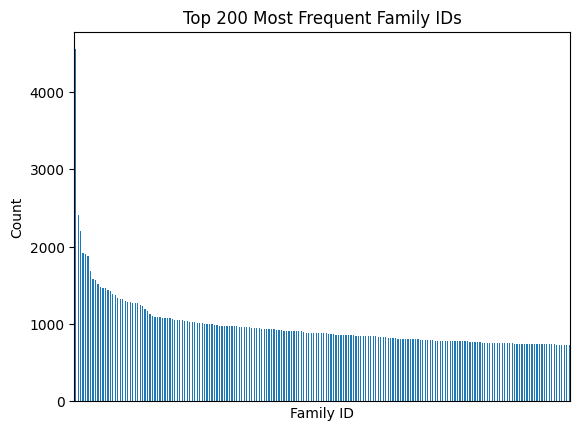

In [12]:
nb_families_to_plot = 200

family_id_counts = df_full['family_id'].value_counts()
top_family_id_counts = family_id_counts.head(nb_families_to_plot)

top_family_id_counts.plot(kind='bar')
plt.title(f'Top {nb_families_to_plot} Most Frequent Family IDs')
plt.xlabel('Family ID')
plt.ylabel('Count')
plt.xticks([])
plt.show()

In [13]:
family_id_counts.describe()

count    17929.000000
mean        74.688103
std        144.505273
min          1.000000
25%          9.000000
50%         26.000000
75%         80.000000
max       4545.000000
Name: family_id, dtype: float64

Conclusion: The dataset is unbalanced.  

We will attempt to construct a model using the top 300 classes.  
In a real-world application, it would be possible to create a model for categorizing protein domains into groups, with each group having its specific model.  
However, for computational efficiency and simplicity, we will only construct a model based on the top 300 classes in this context.

## b) Analysis of the sequences

#### Analysis of the length of the sequences

(0.0, 800.0)

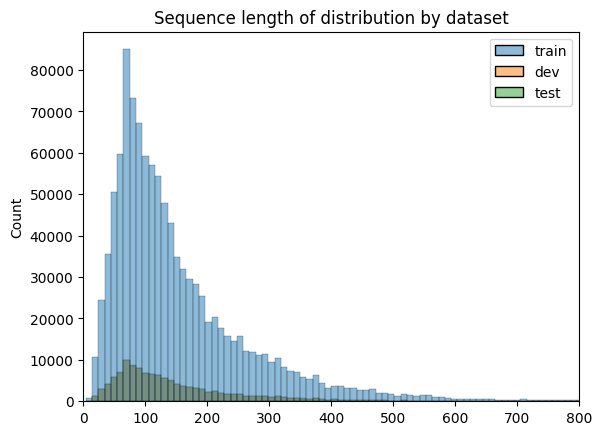

In [14]:
all_sequence_lengths = []
split_types = []
for split, df in zip(["train", "dev", "test"], [df_train, df_dev, df_test]):
    sequences_lengths = df['sequence'].apply(len).to_list()
    nb_sequences = len(sequences_lengths)
    all_sequence_lengths += sequences_lengths
    split_types += (nb_sequences * [split])

sns.histplot(x=all_sequence_lengths, hue=split_types, bins=200)
plt.title("Sequence length of distribution by dataset")
plt.xlim((0,800))

In [15]:
df_full["sequence"].apply(len).describe()

count    1.339083e+06
mean     1.551566e+02
std      1.197877e+02
min      4.000000e+00
25%      7.600000e+01
50%      1.190000e+02
75%      1.950000e+02
max      2.037000e+03
Name: sequence, dtype: float64

Most of the sequences have less than 300-400 amino acids.  
Based on these observations, we will truncate the sequences to some value between 300 and 600 (this will be a hyperparameter)

#### Qualitative analysis of the sequences of the same family

Let's examine the sequences of a specific family to determine whether it's easy to identify any patterns, as humans would.

In [16]:
family_id = "LRR_1"
small_df = df_full[df_full["family_id"] == family_id].reset_index(drop=True)
small_df.head(2)

,family_id,sequence_name,family_accession,aligned_sequence,sequence,accession_number,version
0,LRR_1,FMOD_BOVIN/130-154,PF00560.33,GLLWI....A......L...........HGNQ.....IT..........,GLLWIALHGNQITSDKVGKKVFSKL,00560,33
1,LRR_1,Q9EME3_AMEPV/190-210,PF00560.33,NLKNL....I......F...........HKTN.....I...........,NLKNLIFHKTNINSLLDIYNL,00560,33


In [17]:
text = ""
for index, row in small_df[:5].iterrows():
    new_text = f"""--- Protein n° {index+1} ---\nSequence : {row["sequence"]}\nAligned sequence : {row["aligned_sequence"]}\n\n"""
    text = text + new_text

print(text)

--- Protein n° 1 ---
Sequence : GLLWIALHGNQITSDKVGKKVFSKL
Aligned sequence : GLLWI....A......L...........HGNQ.....IT...............SDKVGKKV...FS..........K.L

--- Protein n° 2 ---
Sequence : NLKNLIFHKTNINSLLDIYNL
Aligned sequence : NLKNL....I......F...........HKTN.....I.................N..SLLD...IY..........N.L

--- Protein n° 3 ---
Sequence : SLLRLSLYNNCICDVGAESLARV
Aligned sequence : SLLRL....S......L...........YNNC.....I.................CDVGAES...LA..........R.V

--- Protein n° 4 ---
Sequence : RLKYLSICNTGIHKLPDVTKIF
Aligned sequence : RLKYL....S......I...........CNTG.....I..................HKLPDV...TK..........I.F

--- Protein n° 5 ---
Sequence : GLRYLILECPQITQIPDSLGNL
Aligned sequence : GLRYL...........I...........LECP.....Q.................ITQIPDS...LG..........N.L




As a human, it appears challenging to identify a pattern from the list of sequences, but it becomes more manageable with the aligned sequences.  
We might consider whether we could utilize these aligned sequences for our model.  

However, it's important to note that the aligned sequences are generated using HMMs.  
Since the objective is to enhance the current method (Hidden Markov Models), it would necessitate generating the aligned sequences directly from the sequences themselves.  
This could serve as a topic for future research.

## c) Analysis of the frequency of all the amino acids

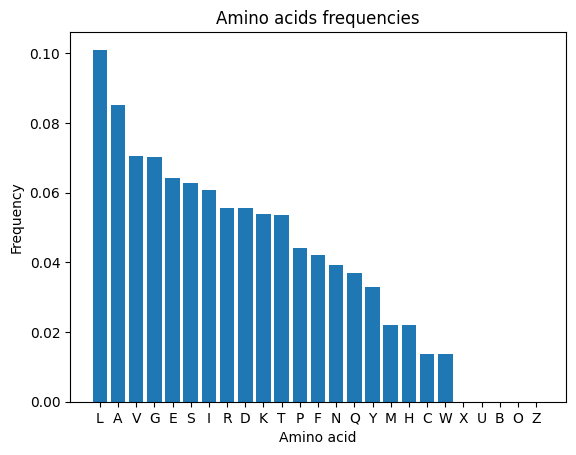

In [18]:
counter = Counter()
df_full['sequence'].apply(lambda seq: counter.update(list(seq)))

amino_acids_counts = list(counter.items())
amino_acids_counts.sort(key=lambda x: x[1], reverse=True)

amino_acids_names, amino_acids_frequencies = [], []
for aa, count in amino_acids_counts:
    amino_acids_names.append(aa)
    amino_acids_frequencies.append(count)

amino_acids_frequencies /= np.sum(amino_acids_frequencies)

plt.bar(amino_acids_names, amino_acids_frequencies)
plt.title(f'Amino acids frequencies')
plt.xlabel('Amino acid')
plt.ylabel('Frequency')
plt.show()

We observe that certain amino acids are almost absent in the dataset (X, U, B, O, Z), and thus, we will simply exclude them from the sequences.  
Additionally, we observe that some amino acids (leucine, alanine) are significantly more prevalent than others (cysteine, tryptophan).

In [19]:
amino_acids_to_keep = amino_acids_names[:-5]
amino_acids_to_delete = amino_acids_names[-5:]
print(f"Amino acids to keep : {amino_acids_to_keep}\nAmino acids to delete : {amino_acids_to_delete}")

Amino acids to keep : ['L', 'A', 'V', 'G', 'E', 'S', 'I', 'R', 'D', 'K', 'T', 'P', 'F', 'N', 'Q', 'Y', 'M', 'H', 'C', 'W']
Amino acids to delete : ['X', 'U', 'B', 'O', 'Z']


# **Data Processing**

## Amino acids that we keep in the sequences

Let us define the amino acids that we want to keep in the sequences.  
We also define a dictionary allowing to encode the amino acids by integers.

In [20]:
amino_acids_to_keep = list("ACDEFGHIKLMNPQRSTVWY")
dict_amino_acid_to_int = {aa: idx+1 for idx, aa in enumerate(amino_acids_to_keep)} # We start at 1 (instead of 0), because 0 will be used at the padding token

## Preprocess functions

In [21]:
def encode_amino_acid_sequence(sequence, dict_amino_acid_to_int):
    """
    Encode a protein sequence by mapping each amino acid to its corresponding integer representation.
    Amino acids not found in the dictionary are omitted from the list.

    Args:
        sequence (str): A string representing a protein sequence composed of amino acids (e.g. 'LAGCCT').
        dict_amino_acid_to_int (dict): A dictionary mapping amino acids to their integer codes.

    Returns:
        list: A list of integers where each integer represents an amino acid in the input sequence.
              Amino acids not found in the dictionary are omitted from the list.
    """

    encoded_sequence = []
    for aa in sequence:
        # If the amino acid is not found in the dicitonary, we omit it from the list
        try:
            encoded_sequence.append(dict_amino_acid_to_int[aa])
        except KeyError:
            pass
    return encoded_sequence


def pad_amino_acid_sequence(sequence, sequences_length, padding='post'):
    """
    Pad or truncate a given amino acid sequence to a specified length.

    Args:
        sequence (list): A list of integers representing an encoded amino acid sequence.
        sequences_length (int): The desired length to which the sequence should be padded or truncated.
        padding (str, optional): Specifies whether padding should be added at the beginning ('pre') or
                                 the end ('post') of the sequence. Default is 'post'.

    Returns:
        list: A list of integers representing the amino acid sequence after padding or truncation.
              If the input sequence is longer than the specified length, it is truncated.
              If it is shorter, padding is added accordingly.
    """
    padded_sequence = tf.keras.utils.pad_sequences([sequence],
                                                    maxlen=sequences_length,
                                                    padding=padding)[0]
    return padded_sequence


def preprocess_data(df, label_encoder, classes_to_keep, sequences_length, dict_amino_acid_to_int, padding='post'):
    """
    Preprocesses data for further deep learning process.

    Args:
        df (pd.DataFrame): The input DataFrame containing sequence data.
        label_encoder (sklearn.preprocessing.LabelEncoder): An instance of a label encoder for encoding class labels.
        classes_to_keep (list): A list of class labels to retain in the dataset.
        sequences_length (int): The desired length for sequence padding or truncation.
        dict_amino_acid_to_int (dict): A dictionary mapping amino acids to their integer codes.
        padding (str, optional): Specifies whether padding should be added at the beginning ('pre') or
                                 the end ('post') of the sequences. Default is 'post'.

    Returns:
        tuple: A tuple containing preprocessed input data and labels in the format (X, y).
            - X (numpy.ndarray): An array of padded and encoded protein sequences.
            - y (numpy.ndarray): An array of encoded class labels.
    """
    # Remove some classes
    mask_classes_to_keep = df['family_accession'].isin(classes_to_keep)
    df = df.loc[mask_classes_to_keep, :].reset_index(drop=True)

    # Transform amino acids sequences into list of integers
    df['sequence_encoded'] = df['sequence'].apply(lambda seq: encode_amino_acid_sequence(seq, dict_amino_acid_to_int))
    df['sequence_encoded'] = df['sequence_encoded'].apply(lambda seq: pad_amino_acid_sequence(seq, sequences_length, padding=padding))

    # Encode labels
    df["label"] = label_encoder.transform(df["family_accession"])

    # Shuffle
    df.sample(frac=1).reset_index(drop=True)

    # Return X and y
    X = np.array(df["sequence_encoded"].tolist())
    y = df["label"].to_numpy()
    y_categorical = keras.utils.to_categorical(y, num_classes=len(classes_to_keep))

    return X, y, y_categorical

## Preprocessing parameters


In [22]:
sequences_length = 300
num_classes = 100
padding = 'post'

## Preprocessing

In [23]:
# Compute label encoder for all the classes
classes_counts = df_train['family_accession'].value_counts()
classes_to_keep = list(classes_counts.index[:num_classes])
label_encoder = sklearn.preprocessing.LabelEncoder().fit(classes_to_keep)

# Preprocess the data
X_train, y_train, y_train_categorical = preprocess_data(df_train, label_encoder, classes_to_keep, sequences_length, dict_amino_acid_to_int, padding=padding)
X_dev, y_dev, y_dev_categorical = preprocess_data(df_dev, label_encoder, classes_to_keep, sequences_length, dict_amino_acid_to_int, padding=padding)
X_test, y_test, y_test_categorical = preprocess_data(df_test, label_encoder, classes_to_keep, sequences_length, dict_amino_acid_to_int, padding=padding)

## Classes weights

We will use weights during training because the dataset is very unbalanced

In [24]:
weights_train = sklearn.utils.class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(weights_train))

# Model

## Data parameters

In [25]:
data_params = {
    'input_dim': len(amino_acids_to_keep) + 1, # We add 1 for the token used for padding
    'input_length': sequences_length,
    'num_classes': num_classes
}

## Helper fuctions

In [40]:
def _test_model(class_model, data_params, embedding_params, model_params, input_shape, expected_output_shape, batch_size=4):
    """
    Test the specified model class with given parameters to ensure the expected output shape.
    The purpose is to test the model was correctly implemented.

    Args:
        class_model (class): The model class to be tested.
        data_params (dict): Parameters related to data configuration. This includes the input dimension,
                            the input length, and the number of classes
        embedding_params (dict): Parameters related to embedding layers. This might include the embedding
                                 dimension, or eventually other parameters depending on the model

        model_params (dict): Parameters related to model architecture.
        input_shape (tuple): The shape of the input data (excluding batch size).
        expected_output_shape (tuple): The expected shape of the model's output (excluding batch size).
        batch_size (int, optional): The batch size for testing. Default is 4.

    Returns:
        None

    Raises:
        AssertionError: If the model's output shape does not match the expected shape.

    """
    model = class_model(**data_params, **embedding_params, **model_params)

    input = tf.keras.Input(input_shape, batch_size=batch_size)
    print("Providing the model with input of shape:", input.shape)
    output = model(input)

    expected_output_shape_with_batch = (batch_size,) + expected_output_shape
    print(f"Expedted output:", expected_output_shape_with_batch)

    assert output.shape == expected_output_shape_with_batch, f"Output should be {expected_output_shape_with_batch}, but it is {output.shape}"
    print("Test passed")

In [41]:
def compile_and_train_model(model, X, y_categorical, learning_rate, epochs, batch_size, early_stopping_patience, validation_data=None, validation_split=0, class_weight=None, verbose='auto', **kwargs):
    """
    Compile and train a deep learning model with specified parameters and settings.

    Args:
        model (tf.keras.Model): The deep learning model instance to be compiled and trained.
        X (numpy.ndarray): Input data for training.
        y_categorical (numpy.ndarray): One-hot encoded target labels.
        learning_rate (float): The learning rate for model optimization.
        epochs (int): The number of training epochs.
        batch_size (int): The batch size for training.
        early_stopping_patience (int): The number of epochs with no improvement after which training will be stopped.
        validation_data (tuple): A tuple containing validation data (X_val, y_val) for monitoring model performance
                                 during training. Default set to None.
        validation_split (float): The fraction of training data to use for validation during training. Default set to 0
        class_weight (dict): A dictionary specifying class weights for handling imbalanced datasets. Default set to None.
        verbose (int): Possibles values are 'auto', 0, 1, or 2. Default is set to 'auto'
                       Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
                      'auto' becomes 1 for most cases, but 2 when used with ParameterServerStrategy.
        **kwargs: Additional keyword arguments for model training.

    Returns:
        tf.keras.callbacks.History: A `tf.keras.callbacks.History` object containing training and validation metrics.

    """
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy']) # sparse_categorical_crossentropy

    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                   min_delta=0,
                                                   patience=early_stopping_patience,
                                                   verbose=0,
                                                   mode='auto')

    history = model.fit(X,
                        y_categorical,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=validation_data,
                        validation_split=validation_split,
                        class_weight=class_weight,
                        callbacks=[early_stopping],
                        verbose=verbose)

    return history

In [42]:
def gridsearch(class_model, X_train, y_train_categorical, gridsearch_params, metric='accuracy', verbose=1, **fixed_params):
    """
    Performs a grid search over specified parameter combinations to find the best model configuration.

    Args:
        class_model (class): The model class to be instantiated and trained.
        X_train (array-like): Training data features.
        y_train_categorical (array-like): Training data targets.
        gridsearch_params (dict): Dictionary containing parameter ranges for the grid search,
                                  structured as {'category': {'param_name': [values]}}.
                                  Categories include 'embedding_params', 'model_params', and 'training_params'.
        metric (str, optional): Performance metric to evaluate the model. Possible values are 'accuracy', 'loss'
                                Default is 'accuracy'.
        verbose (int, optional): Verbosity mode for model training.
                                 0 = silent, 1 = progress bar (default), 2 = one line per epoch.
        **fixed_params: Additional fixed parameters for the model that are not part of the grid search.

    The function iterates over all combinations of the specified parameters, training a new model instance
    for each combination and evaluating its performance using the specified metric. It keeps track of the
    best performing parameter combination.

    Returns:
        tuple: A tuple containing the best parameter combination (dict) and the corresponding best score (float).

    """
    def count_nb_steps(gridsearch_params):
        res = 1
        for key, value in gridsearch_params.items():
            for key2, value2 in value.items():
                res *= len(value2)
        return res


    assert metric in ['accuracy', 'loss'], f"Invalid metric: {metric}. Metric must be either 'accuracy' or 'loss'."
    best_score = None
    if metric == 'accuracy':
        best_score = 0
    elif metric == 'loss':
        best_score = float('inf')
    best_params = {}

    # Get params to test
    embedding_grid = list(gridsearch_params['embedding_params'].items())
    model_grid = list(gridsearch_params['model_params'].items())
    training_grid = list(gridsearch_params['training_params'].items())

    # Compute combinations
    all_params_combinations = product(*(list(product([key], value)) for key, value in (embedding_grid + model_grid + training_grid)))

    nb_steps = count_nb_steps(gridsearch_params)

    for i, params_combination in enumerate(all_params_combinations):
        print(f"Step {i+1}/{nb_steps}..")
        # The fixed params
        current_params = {**fixed_params}

        # Add the params to test to the fixed params
        for param, value in params_combination:
            current_params[param] = value

        # Train model
        model = class_model(**current_params)
        history = compile_and_train_model(model, X_train, y_train_categorical, verbose=verbose, **current_params)

        # Compute loss and compare to bets score
        score = None
        if metric == 'accuracy':
            score = np.max(history.history['val_accuracy'])
            if score > best_score:
                best_score = score
                best_params = params_combination

        if metric == 'loss':
            score = np.min(history.history['val_loss'])
            if score < best_score:
                best_score = score
                best_params = params_combination

        # Print
        print(f"Params: {params_combination}, {metric.capitalize()}: {score}\n")

    print(f"Best params: {best_params}, Best {metric}: {best_score}")

    return best_params, best_score

In [43]:
def show_history(history):
    """
    Display training and validation loss and accuracy over epochs.

    Args:
        history (tf.keras.callbacks.History): The training history object containing metrics.

    Returns:
        None

    """
    train_loss = history.history['loss']
    train_accuracy = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_accuracy = history.history['val_accuracy']
    epochs = range(1, len(train_loss) + 1)

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    ax[0].plot(epochs, train_loss, label='Training loss')
    ax[0].plot(epochs, val_loss, label='Validation loss')
    ax[0].set_title('Training and Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(epochs, train_accuracy, label='Training accuracy')
    ax[1].plot(epochs, val_accuracy, label='Validation accuracy')
    ax[1].set_title('Training and Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

In [44]:
def visualize_protein_embeddings(model, X, y, nb_classes_to_analyze=30, nb_proteins_per_class=30, batch_size=32):
    """
    Visualize protein embeddings using t-SNE dimensionality reduction.

    Args:
        model (tf.keras.Model): The trained deep learning model.
        X (numpy.ndarray): Input data containing protein sequences.
        y (numpy.ndarray): Ground truth class labels corresponding to the protein sequences.
        nb_classes_to_analyze (int, optional): The number of top classes to analyze. Default is 30.
        nb_proteins_per_class (int, optional): The maximum number of proteins to analyze per class. Default is 30.
        batch_size (int, optional): The batch size for computing embeddings. Default is 32.

    Returns:
        None

    Note:
        To use this function, ensure that the provided model has a 'get_embedding_before_classification' method.
        This method should return the embeddings of protein sequences before the final classification layer.

    """
    # Compute top classes based on class frequency
    unique_classes, class_counts = np.unique(y_train, return_counts=True)
    sorted_classes = unique_classes[np.argsort(class_counts)[::-1]]
    top_classes = sorted_classes[:nb_classes_to_analyze]

    # Filter data to select top classes and limit the number of proteins per class
    filtered_indices = []
    for class_label in top_classes:
        indices_for_class = np.where(y == class_label)[0]
        if len(indices_for_class) > nb_proteins_per_class:
            indices_for_class = indices_for_class[:nb_proteins_per_class]
        filtered_indices.extend(indices_for_class)

    X = X[filtered_indices]
    y = y[filtered_indices]

    # Compute protein embeddings in batches
    embeddings_list = []

    for i in range(0, len(X), batch_size):
        batch_X = X[i:i+batch_size]
        batch_embeddings = model.get_embedding_before_classification(batch_X)
        embeddings_list.append(batch_embeddings)

    embeddings = np.concatenate(embeddings_list, axis=0)

    # Perform t-SNE dimensionality reduction for visualization
    tsne = TSNE(n_components=2)
    embeddings_tsne = tsne.fit_transform(embeddings)

    # Assign random colors to class labels
    class_colors = {}
    for label in top_classes:
        class_colors[label] = np.random.rand(3,)

    # Plot the t-SNE visualization of embeddings
    plt.figure(figsize=(8, 8))
    plt.title("Embeddings of the amino acids")
    for i, (coord_x, coord_y) in enumerate(embeddings_tsne):
        label = y[i]
        color = class_colors[label]
        plt.scatter(coord_x, coord_y, color=color)

    plt.legend()
    plt.show()

## An embedding layer

Let us create a custom Embedding layer to encode a sequence of amino acids.  
To leverage sequential information, this layer will be capable of encoding this sequential data.

Inspired by the original implementation of the Transformer by Vaswani et al. (2017), we have the option to use either an embedding matrix based on the positions of the amino acids or sinusoids and cosines of different frequencies, as Vaswani et al. (2017) did.  
However, they reported that the results are similar in both cases.  
They opted for sinusoids and cosines because they intended their model to handle longer sequences than the ones it was trained on.

Since our case doesn't involve longer sequences (as the sequences are truncated), I will use an embedding matrix for positional embedding.

In [120]:
class EmbeddingLayer(tf.keras.Model):
    def __init__(self, input_dim, embedding_output_dim, input_length, embedding_by_position=False, **kwargs):
        """
        Embedding layer for protein sequences. It consists of an tf.keras.Layer.Embedding based on the different amino acids,
        and eventually an embedding based on the position of every amino acid in the sequence.

        Args:
            input_dim (int): The input dimension, representing the total number of unique amino acids in the dataset (including the padding token).
            embedding_output_dim (int): The output dimension of the embedding layer, determining the size of embedding vectors for each amino acid.
            input_length (int): The input length, which isthe length of protein sequences.
            embedding_by_position (bool, optional): Whether to include position-based embeddings. Default is False.

        Returns:
            None
        """
        super().__init__()
        self.amino_acid_embedding = layers.Embedding(input_dim=input_dim, output_dim=embedding_output_dim, input_length=input_length)

        self.embedding_by_position = embedding_by_position
        if self.embedding_by_position:
            self.position_embedding = layers.Embedding(input_dim=input_length, output_dim=embedding_output_dim)
            self.input_length = input_length

    def call(self, inputs, training=False):
        x = self.amino_acid_embedding(inputs)

        if self.embedding_by_position:
            x += self.position_embedding(tf.range(self.input_length))
        return x

def _test():
    embedding_params = {
        'embedding_output_dim': 50,
        'embedding_by_position': True
    }
    model_params = {}

    input_shape = (data_params['input_length'],)
    expected_output_shape = (data_params['input_length'], embedding_params['embedding_output_dim'])

    _test_model(EmbeddingLayer, data_params, embedding_params, model_params, input_shape, expected_output_shape, batch_size=32)

_test()

Providing the model with input of shape: (32, 300)
Expedted output: (32, 300, 50)
Test passed


## A simple feedforward neural network


To start, I will implement and train a straightforward neural network consisting of an embedding layer and two dense layers.  
The objective is to assess the performance of this simplistic model on our classification task.

If it proves effective, we will try to understand the reasons behind its success, such as by analyzing amino acid embeddings, neuron activations, and more.

### Model creation

In [46]:
class FeedforwardNeuralNetwork(tf.keras.Model):
    def __init__(self, num_classes, input_dim, embedding_output_dim, input_length, nb_dense_units=128, dropout_rate=0.2, embedding_by_position=False, **kwargs):
        """
        A simple feedforward neural network model for our classification problem.
        It is composed of two dense layers

        Args:
            num_classes (int): Number of target classes for classification.
            input_dim (int): The input dimension, representing the total number of unique amino acids in the dataset (including the padding token).
            embedding_output_dim (int): The output dimension of the embedding layer, determining the size of embedding vectors for each amino acid.
            input_length (int): The input length, typically the maximum sequence length for protein sequences.
            nb_dense_units (int, optional): The number of units in the dense hidden layer. Default is 128.
            dropout_rate (float, optional): Dropout rate for regularization. Default is 0.2.
            embedding_by_position (bool, optional): Whether to include position-based embeddings. Default is False.

        Returns:
            None

        Methods:
            call(inputs, training=False): The forward pass of the model.
            get_embedding_before_classification(inputs, training=False): Retrieves the representation of the input just before the classification layer.

        The `call` method defines the forward pass of the model and returns the output of the softmax layer.
        The `get_embedding_before_classification` method is useful for extracting the learned representations before the final classification is applied,
        which can be useful for analysis (or transfer learning eventually, but not for this notebook).

        """
        super().__init__()
        self.embedding_layer = EmbeddingLayer(input_dim=input_dim,
                                             embedding_output_dim=embedding_output_dim,
                                             input_length=input_length,
                                             embedding_by_position=embedding_by_position)

        self.flatten = layers.Flatten()
        self.dense = layers.Dense(nb_dense_units, activation='relu')
        self.dropout = layers.Dropout(dropout_rate)
        self.dense_softmax = layers.Dense(num_classes, activation='softmax')

        self.activations = {} # We will use this to analyze the activations of the model

    def call(self, inputs, training=False):
        x = self.embedding_layer(inputs)
        x = self.flatten(x)
        self.activations['embedding'] = x

        x = self.dense(x)
        self.activations['dense'] = x

        x = self.dropout(x, training=training)

        x = self.dense_softmax(x)
        self.activations['softmax'] = x

        return x

    def get_embedding_before_classification(self, inputs, training=False):
        """
        This method calls all the layers of the neural network, excepted the last one (the one that performs the softmax activation function)
        This provides embeddings for the inputs
        """
        x = self.embedding_layer(inputs)
        x = self.flatten(x)
        x = self.dense(x)
        x = self.dropout(x, training=training)

        return x


def _test():
    embedding_params = {
        'embedding_output_dim': 50,
        'embedding_by_position': True
    }
    model_params = {
        'nb_dense_units': 256,
        'dropout_rate': 0.2
    }

    input_shape = (data_params['input_length'],)
    expected_output_shape = (data_params['num_classes'],)

    _test_model(FeedforwardNeuralNetwork, data_params, embedding_params, model_params, input_shape, expected_output_shape, batch_size=32)


_test()

Providing the model with input of shape: (32, 300)
Expedted output: (32, 100)
Test passed


### GridSearch

In [47]:
embedding_params = {
    'embedding_by_position': False
}
model_params = {
    'dropout_rate': 0.2,
    'nb_dense_units': 128
}
training_params = {
    'learning_rate': 1e-3,
    'batch_size': 64,
    'epochs': 30,
    'early_stopping_patience': 4,
    'validation_data': (X_dev, y_dev_categorical),
    'class_weight': class_weight_dict
}

gridsearch_params = {
    'embedding_params': {
        'embedding_output_dim': [10, 20],
        'embedding_by_position': [True, False]
    },
    'model_params': {
        'nb_dense_units': [128, 256],
        'dropout_rate': [0.1, 0.2]
    },
    'training_params': {
    }
}

I will not conduct a grid search on the entire dataset due to computational time constraints. This is not optimal, but it will still allows to find a good set of hyperparameters.  
We will eventually conduct a more comprehensive search for the best hyperparameters once we identify the architecture that yields the best results.

In [ ]:
best_params, best_score = gridsearch(FeedforwardNeuralNetwork,
                                     X_train[:40000],
                                     y_train_categorical[:40000],
                                     gridsearch_params,
                                     metric='loss',
                                     verbose='auto',
                                     **data_params,
                                     **embedding_params,
                                     **model_params,
                                     **training_params)

In [61]:
print(f"Best params : {best_params}\nBest score : {best_score}")

Best params : (('embedding_output_dim', 20), ('embedding_by_position', False), ('nb_dense_units', 256), ('dropout_rate', 0.2))
Best score : 0.021221822127699852


### Best hyperparameters

In [49]:
embedding_params = {
    'embedding_output_dim': 20,
    'embedding_by_position': False
}
model_params = {
    'nb_dense_units': 256,
    'dropout_rate': 0.2
}
training_params = {
    'learning_rate': 1e-3,
    'batch_size': 64,
    'epochs': 50,
    'early_stopping_patience': 4,
    'validation_data': (X_dev, y_dev_categorical),
    'class_weight': class_weight_dict
}

### Train

In [50]:
model = FeedforwardNeuralNetwork(**data_params, **embedding_params, **model_params)
history = compile_and_train_model(model, X_train, y_train_categorical, **training_params)

Epoch 1/50
1453/1453 [==============================] - 7s 4ms/step - loss: 0.3190 - accuracy: 0.9293 - val_loss: 0.0220 - val_accuracy: 0.9944
Epoch 2/50
1453/1453 [==============================] - 8s 5ms/step - loss: 0.0076 - accuracy: 0.9983 - val_loss: 0.0177 - val_accuracy: 0.9961
Epoch 3/50
1453/1453 [==============================] - 6s 4ms/step - loss: 0.0026 - accuracy: 0.9995 - val_loss: 0.0168 - val_accuracy: 0.9958
Epoch 4/50
1453/1453 [==============================] - 7s 5ms/step - loss: 0.0037 - accuracy: 0.9991 - val_loss: 0.0205 - val_accuracy: 0.9949
Epoch 5/50
1453/1453 [==============================] - 6s 4ms/step - loss: 0.0043 - accuracy: 0.9987 - val_loss: 0.0238 - val_accuracy: 0.9945
Epoch 6/50
1453/1453 [==============================] - 7s 5ms/step - loss: 0.0029 - accuracy: 0.9990 - val_loss: 0.0262 - val_accuracy: 0.9942
Epoch 7/50
1453/1453 [==============================] - 8s 6ms/step - loss: 0.0029 - accuracy: 0.9991 - val_loss: 0.0246 - val_accuracy:

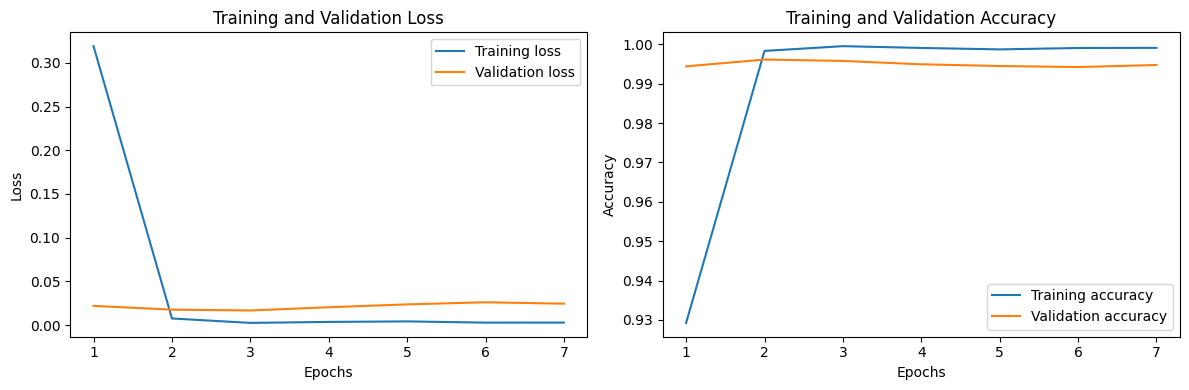

In [51]:
show_history(history)

### Tests

In [52]:
loss, accuracy = model.evaluate(X_test, y_test_categorical)
print("Accuracy on test : ", accuracy)

362/362 [==============================] - 1s 2ms/step - loss: 0.0274 - accuracy: 0.9940
Accuracy on test :  0.994033694267273


### Analysis of the model

#### The amino acids embeddings

In [53]:
# Encode amino acids
amino_acids_encoded = encode_amino_acid_sequence(amino_acids_to_keep, dict_amino_acid_to_int)
amino_acids_encoded_padded = pad_amino_acid_sequence(amino_acids_encoded, sequences_length=sequences_length, padding=padding)

# Compute embeddings
output = model.embedding_layer(np.array([amino_acids_encoded_padded]))
embeddings = output[0, 0:len(amino_acids_to_keep), :]

##### Visualization with Principal Component Analysis (PCA)

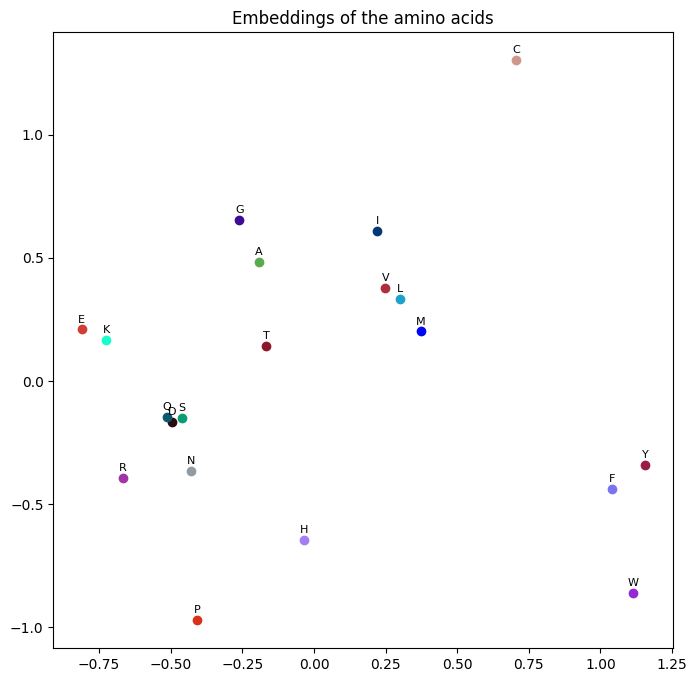

In [54]:
# Compute PCA
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

# Show
plt.figure(figsize=(8, 8))
plt.title("Embeddings of the amino acids")
for i, (x, y) in enumerate(embeddings_pca):
    plt.scatter(x, y, color=np.random.rand(3,))
    plt.annotate(amino_acids_to_keep[i], (x, y), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8)

plt.show()

We notice that amino acids that share some properties are close to each other. For instance :
- Leucine and Isoleucine are close to each other
- Aromatic amino acids (Tryptophan, Tyrosin, Phenylalanin) are close to each other
- Cystein is very far, because it is a special amino acid (it is the only one that can realize sulfure bridges)

It seems that the model captured some properties of amino acids, so it seems that the embedding is working well.  
We will keep this embedding layer for the next steps.

##### Similarity between amino acids

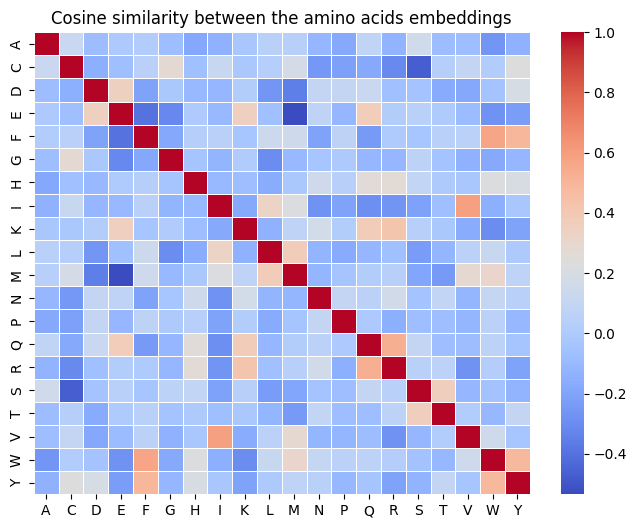

In [55]:
# Compute similarities
similarities = sklearn.metrics.pairwise.cosine_similarity(embeddings)

# Show heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(similarities, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5,
            xticklabels=amino_acids_to_keep, yticklabels=amino_acids_to_keep)  # Utilisation des labels pour les axes
plt.title('Cosine similarity between the amino acids embeddings')
plt.show()

This confirms what the previous figure shows.

#### The protein embeddings

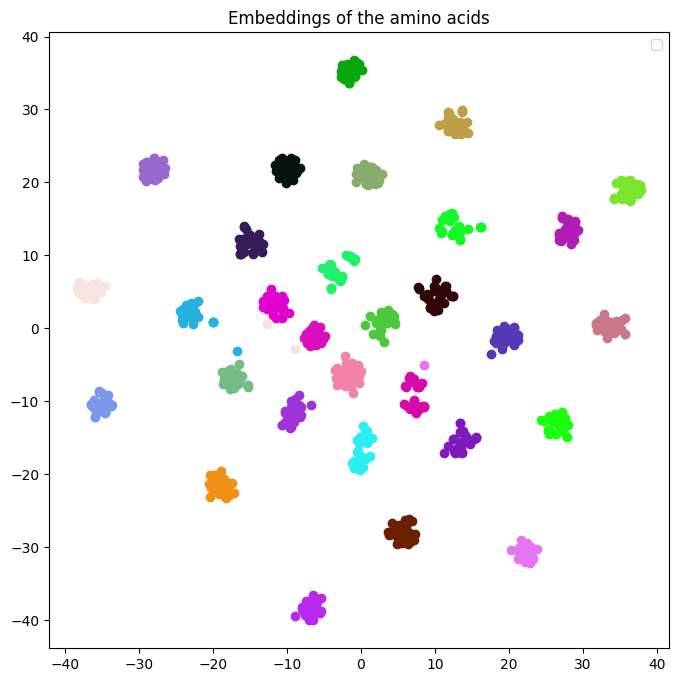

In [56]:
visualize_protein_embeddings(model, X_train, y_train, nb_classes_to_analyze=30, nb_proteins_per_class=30)

The model has been able to make a great separation between all the protein domains.

#### Visualization of the neurons activation

In [57]:
# Parameters
nb_classes_to_compare = 5
nb_proteins_to_keep_per_class = 20

# Compute the labels to compare
unique_labels = np.unique(y_train)
labels_to_compare = unique_labels[:nb_classes_to_compare]

In [59]:
# Initialize list that will contain the activations
all_X = []
all_activations = {'embedding': [], 'dense': [], 'softmax': []}

# Get all the activation values
for label in labels_to_compare:
    X = X_train[y_train == label][:nb_proteins_to_keep_per_class]
    all_X.append(X)
    _ = model(X)

    for key, value in model.activations.items():
        all_activations[key].append(value[:, :200]) # We only keep the 150 first values of every layer, in order to be able to see something

# Convert to numpy
all_X = np.concatenate(all_X, axis=0)
for key, value in all_activations.items():
    all_activations[key] = np.concatenate(value, axis=0)

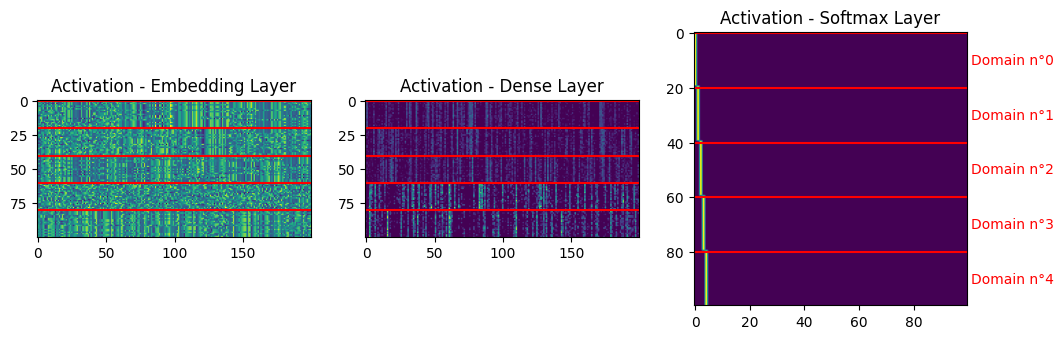

In [60]:
# Show
plt.figure(figsize=(12, 12))

cmap = 'viridis'
for subplot, layer in zip([131, 132, 133], ['embedding', 'dense', 'softmax']):
    plt.subplot(subplot)
    plt.imshow(all_activations[layer], cmap=cmap)
    plt.title(f'Activation - {layer.capitalize()} Layer')
    for i in range(nb_classes_to_compare):
        plt.axhline(y=i*nb_proteins_to_keep_per_class, color='red')

        if subplot == 133:
            plt.text(x=all_activations[layer].shape[-1] + 1,
                     y=(i + 1/2)*nb_proteins_to_keep_per_class,
                     s=f'Domain n°{i}',
                     color='red',
                     va='center')

plt.show()

For multiple sequences from a same family, we can see that there are some common areas in the first embedding.
It shows that the model was able to find some patterns in the amino acid sequences.
We can also see that the neurons that activate in the dense layer are (almost) always the same for a same family.

## Convolutional Neural Network

### Model creation

The following model is a simple CNN, followed by two dense layers.  
A particulariy of this CNN is that there are filters with different sizes.  
This is inspired by Bileschi et al. (2019) (see in references)

In [63]:
class CNN(tf.keras.Model):
    def __init__(self, num_classes, input_dim, embedding_output_dim, input_length, nb_filters_per_kernel_size=16, kernel_sizes=[9], nb_dense_units=256, dropout_rate=0.2, embedding_by_position=False, **kwargs):
        """
        This model applies a convolutional neural network to sequences for classification purposes.
        It includes an embedding layer, multiple convolutional layers, a dense layer, and a softmax output layer.
        The model can handle varying kernel sizes for convolutional layers.

        Args:
            num_classes (int): Number of target classes for classification.
            input_dim (int): The input dimension, representing the total number of unique amino acids in the dataset (including the padding token).
            embedding_output_dim (int): The output dimension of the embedding layer, determining the size of embedding vectors for each amino acid.
            input_length (int): The input length, typically the maximum sequence length for protein sequences.
            nb_filters_per_kernel_size (int, optional): The number of filters per kernel size in the convolutional layers. Default set to 16.
            kernel_sizes (list, optional): A list of kernel sizes for the convolution filters. Default set to [9].
            nb_dense_units (int, optional): The number of units in the dense layer following the convolutional layers. Default set to 256.
            dropout_rate (float, optional): The dropout rate applied after the dense layer for regularization. Default set to 0.2.
            embedding_by_position (bool, optional): A flag to indicate whether positional embeddings should be used. Default set to False.

        Methods:
            call(inputs, training=False): The forward pass of the model.
            get_embedding_before_classification(inputs, training=False): Retrieves the representation of the input just before the classification layer.

        The `call` method defines the forward pass of the model and returns the output of the softmax layer.
        The `get_embedding_before_classification` method is useful for extracting the learned representations before the final classification is applied,
        which can be useful for analysis (or transfer learning eventually, but not for this notebook).
        """
        super().__init__()
        self.embedding_layer = EmbeddingLayer(input_dim=input_dim,
                                              embedding_output_dim=embedding_output_dim,
                                              input_length=input_length,
                                              embedding_by_position=embedding_by_position)
        self.flatten = layers.Flatten()

        self.convs = [layers.Conv1D(filters=nb_filters_per_kernel_size, kernel_size=kernel_size, activation='relu', padding='same') for kernel_size in kernel_sizes]
        self.dense = layers.Dense(nb_dense_units, activation='relu')
        self.dropout = layers.Dropout(dropout_rate)
        self.dense_softmax = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs, training=False):
        x = self.embedding_layer(inputs)
        x = tf.concat([conv(x) for conv in self.convs], axis=-1)
        x = self.flatten(x)
        x = self.dense(x)
        x = self.dropout(x, training)
        x = self.dense_softmax(x)
        return x

    def get_embedding_before_classification(self, inputs, training=False):
        x = self.embedding_layer(inputs)
        x = tf.concat([conv(x) for conv in self.convs], axis=-1)
        x = self.flatten(x)
        x = self.dense(x)
        x = self.dropout(x, training)
        return x

def _test():
    embedding_params = {
        'embedding_output_dim': 20,
        'embedding_by_position': True
    }
    model_params = {
        'nb_filters_per_kernel_size': 16,
        'kernel_sizes': [3, 7],
        'nb_dense_units': 256,
        'dropout_rate': 0.2
    }

    input_shape = (data_params['input_length'],)
    expected_output_shape = (data_params['num_classes'],)

    _test_model(CNN, data_params, embedding_params, model_params, input_shape, expected_output_shape, batch_size=32)

_test()

Providing the model with input of shape: (32, 300)
Expedted output: (32, 100)
Test passed


### Gridsearch

In [66]:
embedding_params = {
    'embedding_output_dim': 20,
    'embedding_by_position': False
}

model_params = {
    'nb_dense_units': 256,
    'dropout_rate': 0.3
}
training_params = {
    'learning_rate': 1e-3,
    'batch_size': 64,
    'epochs': 50,
    'early_stopping_patience': 3,
    'validation_data': (X_dev, y_dev_categorical),
    'class_weight': class_weight_dict
}

gridsearch_params = {
    'embedding_params': {
        'embedding_output_dim': [10, 20],
        'embedding_by_position': [True, False]
    },
    'model_params': {
        'kernel_sizes': [[7, 13, 19, 25],
                         [7, 11, 15, 17, 19, 21, 23, 25]
        ],
        'nb_filters_per_kernel_size': [16, 32]
    },
    'training_params': {
    }
}

In [67]:
best_params, best_score = gridsearch(CNN,
                                     X_train[:40000],
                                     y_train_categorical[:40000],
                                     gridsearch_params,
                                     metric='loss',
                                     verbose=0,
                                     **data_params,
                                     **embedding_params,
                                     **model_params,
                                     **training_params)

Step 1/16..
Params: (('embedding_output_dim', 10), ('embedding_by_position', True), ('kernel_sizes', [7, 13, 19, 25]), ('nb_filters_per_kernel_size', 16)), Loss: 0.0242785532027483

Step 2/16..
Params: (('embedding_output_dim', 10), ('embedding_by_position', True), ('kernel_sizes', [7, 13, 19, 25]), ('nb_filters_per_kernel_size', 32)), Loss: 0.025506209582090378

Step 3/16..
Params: (('embedding_output_dim', 10), ('embedding_by_position', True), ('kernel_sizes', [7, 11, 15, 17, 19, 21, 23, 25]), ('nb_filters_per_kernel_size', 16)), Loss: 0.02443099580705166

Step 4/16..
Params: (('embedding_output_dim', 10), ('embedding_by_position', True), ('kernel_sizes', [7, 11, 15, 17, 19, 21, 23, 25]), ('nb_filters_per_kernel_size', 32)), Loss: 0.019009696319699287

Step 5/16..
Params: (('embedding_output_dim', 10), ('embedding_by_position', False), ('kernel_sizes', [7, 13, 19, 25]), ('nb_filters_per_kernel_size', 16)), Loss: 0.030151689425110817

Step 6/16..
Params: (('embedding_output_dim', 10),

In [68]:
print(f"Best params : {best_params}\nBest score : {best_score}")

Best params : (('embedding_output_dim', 20), ('embedding_by_position', False), ('kernel_sizes', [7, 11, 15, 17, 19, 21, 23, 25]), ('nb_filters_per_kernel_size', 32))
Best score : 0.012655646540224552


### Best hyperparameters

In [71]:
embedding_params = {
    'embedding_output_dim': 20,
    'embedding_by_position': False
}
model_params = {
    'nb_filters_per_kernel_size': 32,
    'kernel_sizes': [7, 11, 15, 17, 19, 21, 23, 25],
    'nb_dense_units': 256,
    'dropout_rate': 0.3
}
training_params = {
    'learning_rate': 1e-3,
    'batch_size': 64,
    'epochs': 50,
    'early_stopping_patience': 4,
    'validation_data': (X_dev, y_dev_categorical),
    'class_weight': class_weight_dict
}

### Train

In [72]:
model = CNN(**data_params, **embedding_params, **model_params)
history = compile_and_train_model(model, X_train, y_train_categorical, **training_params)

Epoch 1/50
1453/1453 [==============================] - 30s 18ms/step - loss: 0.2238 - accuracy: 0.9473 - val_loss: 0.0147 - val_accuracy: 0.9956
Epoch 2/50
1453/1453 [==============================] - 24s 16ms/step - loss: 0.0145 - accuracy: 0.9962 - val_loss: 0.0104 - val_accuracy: 0.9968
Epoch 3/50
1453/1453 [==============================] - 24s 16ms/step - loss: 0.0068 - accuracy: 0.9980 - val_loss: 0.0132 - val_accuracy: 0.9966
Epoch 4/50
1453/1453 [==============================] - 29s 20ms/step - loss: 0.0062 - accuracy: 0.9981 - val_loss: 0.0133 - val_accuracy: 0.9968
Epoch 5/50
1453/1453 [==============================] - 27s 18ms/step - loss: 0.0034 - accuracy: 0.9991 - val_loss: 0.0115 - val_accuracy: 0.9973
Epoch 6/50
1453/1453 [==============================] - 27s 18ms/step - loss: 0.0037 - accuracy: 0.9989 - val_loss: 0.0092 - val_accuracy: 0.9981
Epoch 7/50
1453/1453 [==============================] - 27s 19ms/step - loss: 0.0034 - accuracy: 0.9989 - val_loss: 0.0141 -

### Tests

In [73]:
loss, accuracy = model.evaluate(X_test, y_test_categorical)
print("Accuracy on test : ", accuracy)

362/362 [==============================] - 3s 6ms/step - loss: 0.0070 - accuracy: 0.9987
Accuracy on test :  0.9987030029296875


### Analysis of the model

#### Protein embeddings

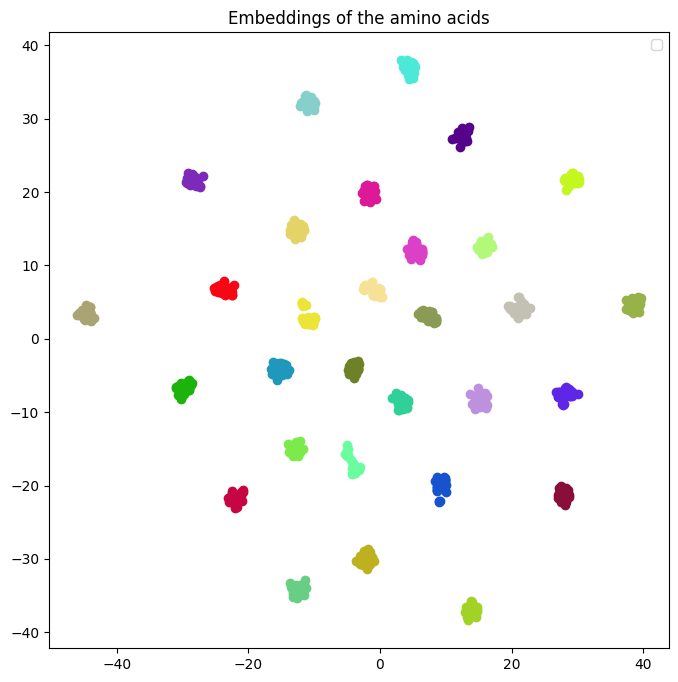

In [74]:
visualize_protein_embeddings(model, X_train, y_train, nb_classes_to_analyze=30, nb_proteins_per_class=30)

## Residual neural network

### Model creation

In [75]:
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, layer_index, num_first_dilated_layer=2, dilation_rate=2, bottleneck_factor=0.5, nb_filters_per_kernel_size=100, kernel_sizes=[9, 17], dropout_rate=0.2, **kwargs):
        """
        This layer implements a single residual block, which is a fundamental building block in Residual Networks.
        It consists of two convolution layers, which are eventually dilated, and a residual connection.
        The first convolutional layer is applied in parallel for different kernel sizes and the results are concatenated.
        This is followed by a bottleneck layer (a convolutional layer with a kernel size of 1) to reduce dimensionality.
        Dropout and ReLU activation are used after each convolutional layer.
        The output of the block is the sum of its input and its processed signal (residual connection), which helps to
        mitigate the vanishing gradient problem in deep networks.

        Args:
            layer_index (int): The index of the layer in the overall network architecture, used for calculating the dilation rate.
            num_first_dilated_layer (int): The layer index at which dilation begins. Default is 2.
            dilation_rate (int): The base dilation rate that is exponentially increased with the layer index. Default is 2.
            bottleneck_factor (float): A scaling factor for reducing the dimensionality in the bottleneck. Default is 0.5.
            nb_filters_per_kernel_size (int): The number of filters for each kernel size in the convolutional layers. Default is 100.
            kernel_sizes (list of int): The sizes of the kernels used in the convolutional layers. Default is [9, 17].
            dropout_rate (float): Dropout rate used for regularization in the block. Default is 0.2.


        The `call` method defines the forward pass through the residual block.

        Example:
            # Example usage in a larger model
            residual_block = ResidualBlock(...)
            output = residual_block(input_tensor)

        """
        super().__init__()
        self.layer_index = layer_index

        # Calculate dilation rate for this block
        shifted_layer_index = (layer_index + 1) - num_first_dilated_layer + 1
        self.dilation_rate = max(1, dilation_rate ** shifted_layer_index)

        self.num_bottleneck_units = int(math.floor(bottleneck_factor * nb_filters_per_kernel_size))

        # First Convolution Layer in the Residual Block
        self.list_conv1 = [tf.keras.layers.Conv1D(
            filters=self.num_bottleneck_units,
            kernel_size=kernel_size,
            padding='same',
            dilation_rate=self.dilation_rate
        ) for kernel_size in kernel_sizes]

        # Second Convolution Layer in the Residual Block
        self.conv2 = tf.keras.layers.Conv1D(
            filters=nb_filters_per_kernel_size*len(kernel_sizes),
            kernel_size=1,  # kernel size of 1 for the linear transformation
            padding='same'
        )

        self.relu = layers.ReLU()
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, inputs, training):
        x = inputs
        # x = tf.keras.layers.BatchNormalization()(x)
        x = self.relu(x)
        x = tf.concat([conv(x) for conv in self.list_conv1], axis=-1)
        x = self.dropout(x, training=training)
        # x = tf.keras.layers.BatchNormalization()(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.dropout(x, training=training)
        x += inputs

        return x

def _test():
    embedding_params = {}
    model_params = {
        'layer_index': 0,
        'num_first_dilated_layer': 2,
        'dilation_rate': 2,
        'bottleneck_factor': 0.5,
        'nb_filters_per_kernel_size': 16,
        'kernel_sizes': [3, 9],
        'dropout_rate': 0.2
    }

    latent_dim = model_params['nb_filters_per_kernel_size'] * len(model_params['kernel_sizes'])

    input_shape = (data_params['input_length'], latent_dim)
    expected_output_shape = (data_params['input_length'], latent_dim)

    _test_model(ResidualBlock, data_params, embedding_params, model_params, input_shape, expected_output_shape, batch_size=32)


_test()

Providing the model with input of shape: (32, 300, 32)
Expedted output: (32, 300, 32)
Test passed


For residual networks, some researchers use max pooling before feeding the input to the last dense layers.  
However, I found that a Flatten layer leads to better results, this is why I used a Flatten layer instead of a max pooling (I could not perform a gridsearch on this parameter too, it already requires too much computation power)

In [90]:
class ProteinResNet(tf.keras.Model):
    def __init__(self, num_classes, input_dim, embedding_output_dim, input_length, num_layers=5, num_first_dilated_layer=2, dilation_rate=2, bottleneck_factor=0.5, nb_filters_per_kernel_size=100, kernel_sizes=[9, 17], nb_dense_units=256, dropout_rate=0.2, embedding_by_position=False, **kwargs):
        """
        A specialized implementation of the Residual Network (ResNet) for protein sequence classification.
        The model begins with an embedding layer, followed by a series of convolutional layers and a series of residual blocks.
        The output of the residual blocks is then flattened and passed through a dense layer with softmax activation for classification.

        Args:
            num_classes (int): Number of target classes for classification.
            input_dim (int): The input dimension, representing the total number of unique amino acids.
            embedding_output_dim (int): The output dimension of the embedding layer.
            input_length (int): The input length, typically the maximum sequence length for protein sequences.
            num_layers (int, optional): The number of residual blocks in the network. Default is 5.
            num_first_dilated_layer (int, optional): The layer index at which dilation begins in the residual blocks.
                                                     Default is 2.
            dilation_rate (int, optional): The base dilation rate for the residual blocks. Default is 2.
            bottleneck_factor (float, optional): A factor to control the bottleneck size in the residual blocks.
                                                 Default is 0.5.
            nb_filters_per_kernel_size (int, optional): The number of filters per kernel size in the convolutional layers.
                                                        Default is 100.
            kernel_sizes (list of int, optional): The sizes of the kernels used in the convolutional layers.
                                                  Default is [9, 17].
            nb_dense_units (int, optional): The number of units in the final dense layer. Default is 256.
            dropout_rate (float, optional): Dropout rate for regularization. Default is 0.2.
            embedding_by_position (bool, optional): Whether to include position-based embeddings. Default is False.

        Methods:
            call(inputs, training=False): The forward pass of the model.
            get_embedding_before_classification(inputs, training=False): Retrieves the representation of the input just before the classification layer.

        The `call` method defines the forward pass of the model and returns the output of the softmax layer.
        The `get_embedding_before_classification` method is useful for extracting the learned representations before the final classification is applied,
        which can be useful for analysis (or transfer learning eventually, but not for this notebook).

        """
        super().__init__()
        self.embedding_layer = EmbeddingLayer(input_dim=input_dim,
                                              embedding_output_dim=embedding_output_dim,
                                              input_length=input_length,
                                              embedding_by_position=embedding_by_position)

        self.convs = [tf.keras.layers.Conv1D(
            filters=nb_filters_per_kernel_size,
            kernel_size=kernel_size,
            padding='same'
        ) for kernel_size in kernel_sizes]

        self.residual_blocks = [ResidualBlock(layer_index=i,
                                              num_first_dilated_layer=num_first_dilated_layer,
                                              dilation_rate=dilation_rate,
                                              bottleneck_factor=bottleneck_factor,
                                              nb_filters_per_kernel_size=nb_filters_per_kernel_size,
                                              kernel_sizes=kernel_sizes,
                                              dropout_rate=dropout_rate) for i in range(num_layers)]

        self.dense = layers.Dense(nb_dense_units, activation='relu')
        self.dense_softmax = layers.Dense(num_classes, activation='softmax')
        self.dropout = layers.Dropout(dropout_rate)

    def call(self, inputs, training=False):
        x = self.embedding_layer(inputs)
        x = self.dropout(x, training=training)

        x = tf.concat([conv(x) for conv in self.convs], axis=-1)
        x = self.dropout(x, training=training)

        for residual_block in self.residual_blocks:
            x = residual_block(x, training)

        x = layers.Flatten()(x) # Better than max pooling
        x = self.dense(x)
        x = self.dropout(x, training=training)

        x = self.dense_softmax(x)

        return x

    def get_embedding_before_classification(self, inputs, training=False):
        x = self.embedding_layer(inputs)
        x = self.dropout(x, training=training)

        x = tf.concat([conv(x) for conv in self.convs], axis=-1)
        x = self.dropout(x, training=training)

        for residual_block in self.residual_blocks:
            x = residual_block(x, training)

        x = layers.Flatten()(x) # Works better than max pooling
        x = self.dense(x)
        x = self.dropout(x, training=training)

        return x

def _test():
    embedding_params = {
        'embedding_output_dim': 20,
        'embedding_by_position': False
    }
    model_params = {
        'num_layers': 5,
        'num_first_dilated_layer': 2,
        'dilation_rate': 2,
        'bottleneck_factor': 0.5,
        'nb_filters_per_kernel_size': 16,
        'kernel_sizes': [7, 11, 15, 17, 19, 21, 23, 25],
        'nb_dense_units': 256,
        'dropout_rate': 0.4
    }

    input_shape = (data_params['input_length'],)
    expected_output_shape = (data_params['num_classes'],)

    _test_model(ProteinResNet, data_params, embedding_params, model_params, input_shape, expected_output_shape, batch_size=8)

_test()

Providing the model with input of shape: (8, 300)
Expedted output: (8, 100)
Test passed


### Gridsearch

In [91]:
embedding_params = {
    'embedding_output_dim': 20,
    'embedding_by_position': False
}
model_params = {
    'num_layers': 2,
    'num_first_dilated_layer': 2,
    'dilation_rate': 2,
    'bottleneck_factor': 0.5,
    'nb_filters_per_kernel_size': 16,
    'kernel_sizes': [7, 11, 15, 17, 19, 21, 23, 25],
    'nb_dense_units': 128,
    'dropout_rate': 0.2
}
training_params = {
    'learning_rate': 1e-3,
    'batch_size': 64,
    'epochs': 30,
    'early_stopping_patience': 2,
    'validation_data': (X_dev, y_dev_categorical),
    'class_weight': class_weight_dict
}

gridsearch_params = {
    'embedding_params': {
    },
    'model_params': {
        'num_layers': [1, 2],
        'nb_filters_per_kernel_size': [16, 32],
        'nb_dense_units': [128, 256]
    },
    'training_params': {
    }
}

best_params, best_score = gridsearch(ProteinResNet,
                                     X_train[:40000],
                                     y_train_categorical[:40000],
                                     gridsearch_params,
                                     metric='loss',
                                     verbose='auto',
                                     **data_params,
                                     **embedding_params,
                                     **model_params,
                                     **training_params)

Step 1/8..
Epoch 1/30
625/625 [==============================] - 27s 33ms/step - loss: 0.4527 - accuracy: 0.8915 - val_loss: 0.0370 - val_accuracy: 0.9901
Epoch 2/30
625/625 [==============================] - 19s 30ms/step - loss: 0.0359 - accuracy: 0.9894 - val_loss: 0.0368 - val_accuracy: 0.9906
Epoch 3/30
625/625 [==============================] - 18s 29ms/step - loss: 0.0266 - accuracy: 0.9915 - val_loss: 0.0485 - val_accuracy: 0.9889
Epoch 4/30
625/625 [==============================] - 17s 28ms/step - loss: 0.0367 - accuracy: 0.9897 - val_loss: 0.0485 - val_accuracy: 0.9909
Params: (('num_layers', 1), ('nb_filters_per_kernel_size', 16), ('nb_dense_units', 128)), Loss: 0.036832213401794434

Step 2/8..
Epoch 1/30
625/625 [==============================] - 26s 30ms/step - loss: 0.3375 - accuracy: 0.9204 - val_loss: 0.0365 - val_accuracy: 0.9909
Epoch 2/30
625/625 [==============================] - 19s 30ms/step - loss: 0.0243 - accuracy: 0.9930 - val_loss: 0.0435 - val_accuracy: 0.9

In [92]:
print(f"Best params : {best_params}\nBest score : {best_score}")

Best params : (('num_layers', 2), ('nb_filters_per_kernel_size', 16), ('nb_dense_units', 128))
Best score : 0.029701653867959976


### Best hyperparameters

In [93]:
embedding_params = {
    'embedding_output_dim': 20,
    'embedding_by_position': False
}
model_params = {
    'num_layers': 2,
    'num_first_dilated_layer': 2,
    'dilation_rate': 2,
    'bottleneck_factor': 0.5,
    'nb_filters_per_kernel_size': 16,
    'kernel_sizes': [7, 11, 15, 17, 19, 21, 23, 25],
    'nb_dense_units': 128,
    'dropout_rate': 0.2
}
training_params = {
    'learning_rate': 1e-3,
    'batch_size': 64,
    'epochs': 30,
    'early_stopping_patience': 2,
    'validation_data': (X_dev, y_dev_categorical),
    'class_weight': class_weight_dict
}

### Train

In [94]:
model = ProteinResNet(**data_params, **embedding_params, **model_params)
history = compile_and_train_model(model, X_train, y_train_categorical, **training_params)

Epoch 1/30
1453/1453 [==============================] - 81s 50ms/step - loss: 0.2452 - accuracy: 0.9398 - val_loss: 0.0209 - val_accuracy: 0.9945
Epoch 2/30
1453/1453 [==============================] - 66s 45ms/step - loss: 0.0412 - accuracy: 0.9887 - val_loss: 0.0250 - val_accuracy: 0.9946
Epoch 3/30
1453/1453 [==============================] - 66s 45ms/step - loss: 0.0365 - accuracy: 0.9908 - val_loss: 0.0252 - val_accuracy: 0.9948


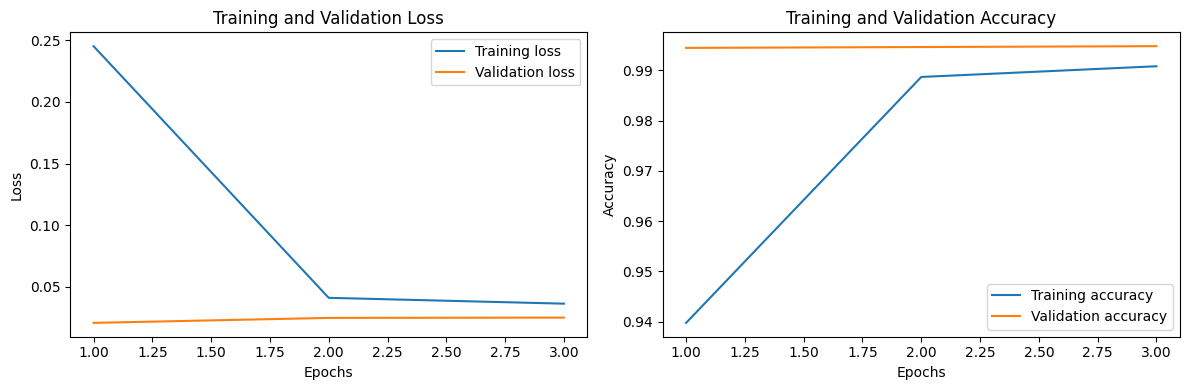

In [95]:
show_history(history)

### Tests

In [96]:
loss, accuracy = model.evaluate(X_test, y_test_categorical)
print("Accuracy on test : ", accuracy)

362/362 [==============================] - 8s 15ms/step - loss: 0.0197 - accuracy: 0.9958
Accuracy on test :  0.9958495497703552


### Analysis of the model

#### Protein embeddings

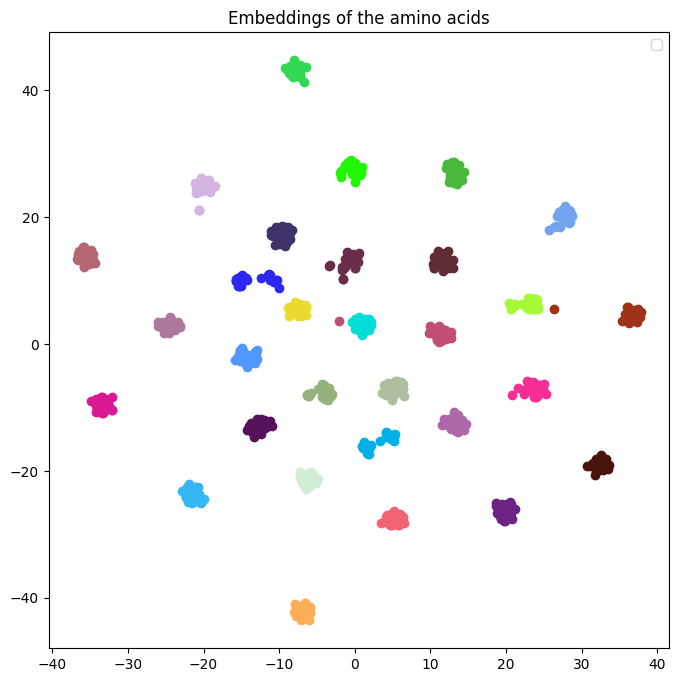

In [97]:
visualize_protein_embeddings(model, X_train, y_train, nb_classes_to_analyze=30, nb_proteins_per_class=30)

## Transformer

### Model creation

In [146]:
class TransformerBlock(tf.keras.Model):
    def __init__(self, num_heads, dim_heads, latent_dim, mlp_dim, dropout_rate=0.1, **kwargs):
        """
        This class implements a standard Transformer block from the Encoder, as described in the paper "Attention Is All You Need".
        It consists of a multi-head self-attention layer and a position-wise feed-forward neural network.
        Each of these two components has a residual connection around it, followed by layer normalization.

        Args:
            num_heads (int): Number of attention heads in the multi-head attention layer.
            dim_heads (int): Dimensionality of each attention head.
            latent_dim (int): The dimensionality of the input and output of the block.
            mlp_dim (int): Dimensionality of the inner layer of the two feed-forward neural networks in the block.
            dropout_rate (float, optional): Dropout rate used for regularization. Default is 0.1.

        """
        super().__init__()
        self.multi_head_attention_layer = layers.MultiHeadAttention(num_heads=num_heads, key_dim=dim_heads)
        self.dense1 = layers.Dense(mlp_dim, activation='relu')
        self.dense2 = layers.Dense(latent_dim, activation='relu')
        self.layer_norm1 = layers.LayerNormalization()
        self.layer_norm2 = layers.LayerNormalization()
        self.dropout = layers.Dropout(dropout_rate)

    def __call__(self, inputs, training=False, attention_mask=None):
        x = self.layer_norm1(inputs)

        attention_output = self.multi_head_attention_layer(x, x, attention_mask=attention_mask)
        attention_output += x

        y = self.layer_norm2(attention_output)
        y = self.dense1(y)
        y = self.dropout(y, training=training)
        y = self.dense2(y)
        y = self.dropout(y, training=training)

        return y + attention_output

def _test():
    model_params = {
        'latent_dim': 20,
        'num_heads': 8,
        'dim_heads': 16,
        'mlp_dim': 30,
        'dropout_rate': 0.2
    }

    input_shape = (data_params['input_length'], embedding_params['embedding_output_dim'])
    expected_output_shape = (data_params['input_length'], embedding_params['embedding_output_dim'])

    _test_model(TransformerBlock, data_params, embedding_params, model_params, input_shape, expected_output_shape, batch_size=32)

_test()

Providing the model with input of shape: (32, 300, 20)
Expedted output: (32, 300, 20)
Test passed


In [159]:
class Transformer(tf.keras.Model):
    def __init__(self, num_classes, input_dim, embedding_output_dim, input_length, num_layers, num_heads, dim_heads, nb_dense_units=2566, mlp_dim=128, dropout_rate=0.1, embedding_by_position=True, pooling_strategy='cls', padding_token=0, **kwargs):
        """
        This class implements a Transformer model.
        The model consists of an embedding layer followed by several Transformer blocks and a final dense layer for classification.

        Args:
            num_classes (int): Number of target classes for classification.
            input_dim (int): The input dimension, typically representing the size of the vocabulary.
            embedding_output_dim (int): The dimensionality of the output space of the embedding layer.
            input_length (int): The length of the input sequences.
            num_layers (int): The number of Transformer blocks to be stacked.
            num_heads (int): Number of attention heads in each Transformer block.
            dim_heads (int): Dimensionality of each attention head.
            nb_dense_units (int, optional): The number of units in the final dense layer. Default is 256.
            mlp_dim (int, optional): Dimensionality of the inner layer of the feed-forward networks in the blocks. Default is 128.
            dropout_rate (float, optional): Dropout rate used for regularization. Default is 0.1.
            embedding_by_position (bool, optional): Whether to include positional embeddings. Default is True.
            pooling_strategy (str, optional): Strategy for pooling the output of the Transformer. Options are 'max_pooling',
                                              'average_pooling', 'cls', and 'flatten'. Default is 'cls'.
            padding_token (int, optional): The token used for the padding. It is used for the attention mask. Default is 0.

        """
        super().__init__()

        # I change input_dim and input_length to take into account the 'cls' token
        # Note that this is not a good way to do it : I should just modify the input_dim and input_length parameters when I initialize the model,
        # but this is more convenient regarding the organization of my code
        input_dim += 1
        input_length += 1

        self.embedding_layer = EmbeddingLayer(input_dim=input_dim,
                                              embedding_output_dim=embedding_output_dim,
                                              input_length=input_length,
                                              embedding_by_position=embedding_by_position)

        self.encoder_blocks = [TransformerBlock(num_heads=num_heads,
                                                dim_heads=dim_heads,
                                                latent_dim=embedding_output_dim,
                                                mlp_dim=mlp_dim,
                                                dropout_rate=dropout_rate) for _ in range(num_layers)]

        self.dense = layers.Dense(nb_dense_units, activation='relu')
        self.dense_softmax = layers.Dense(num_classes, activation='softmax')
        self.dropout = layers.Dropout(dropout_rate)

        available_pooling_strategies = ['max_pooling', 'average_pooling', 'cls', 'flatten']
        assert pooling_strategy in available_pooling_strategies, f"Pooling strategy must be in {available_pooling_strategies}, not {pooling_strategy}"
        self.pooling_strategy = pooling_strategy

        self.padding_token = padding_token

    def __call__(self, inputs, training=False):
        x = self.embedding_layer(inputs)
        x = self.dropout(x, training=training)

        attention_mask = tf.cast(tf.math.not_equal(inputs, self.padding_token), dtype=tf.float32)
        attention_mask = tf.expand_dims(attention_mask, axis=1)

        for encoder in self.encoder_blocks:
            x = encoder(x, training=training, attention_mask=attention_mask)

        x = self.pooling(x)
        x = self.dense_softmax(x)

        return x

    def pooling(self, x):
        if self.pooling_strategy == 'max_pooling':
            x = tf.reduce_max(x, axis=1)
        elif self.pooling_strategy == 'average_pooling':
            x = tf.reduce_mean(x, axis=1)
        elif self.pooling_strategy == 'cls':
            x = x[:, 0, :]
        elif self.pooling_strategy == 'flatten':
            x = layers.Flatten()(x)

        return x

    def get_embedding_before_classification(self, inputs, training=False):
        x = self.embedding_layer(inputs)
        x = self.dropout(x, training=training)

        attention_mask = tf.cast(tf.math.not_equal(inputs, self.padding_token), dtype=tf.float32)
        attention_mask = tf.expand_dims(attention_mask, axis=1)

        for encoder in self.encoder_blocks:
            x = encoder(x, training=training, attention_mask=attention_mask)

        x = self.pooling(x)

        return x


def _test():
    embedding_params = {
        'embedding_output_dim': 50,
        'embedding_by_position': True
    }
    model_params = {
        'num_layers': 4,
        'num_heads': 8,
        'dim_heads': 16,
        'mlp_dim': 30,
        'dropout_rate': 0.2,
        'pooling_strategy': 'max_pooling'
    }

    input_shape = (data_params['input_length']+1,)
    expected_output_shape = (data_params['num_classes'],)

    _test_model(Transformer, data_params, embedding_params, model_params, input_shape, expected_output_shape, batch_size=8)

_test()

Providing the model with input of shape: (8, 301)
Expedted output: (8, 100)
Test passed


### Function to add a 'cls' token

In [160]:
def add_cls_token(X, token_to_add):
    """
    Add a specified token to the beginning of each sequence in a batch.

    Args:
        X (np.ndarray): Input array of shape (batch_size, n), where each row is a sequence.
        token_to_add (int): The token to be added at the beginning of each sequence.

    Returns:
        np.ndarray: Modified array of shape (batch_size, n+1) with the specified token added at the start of each sequence.

    """
    cls_tokens = np.full((X.shape[0], 1), token_to_add)
    X_with_cls = np.hstack((cls_tokens, X))

    return X_with_cls

### Gridsearch

In [197]:
embedding_params = {
    'embedding_output_dim': 20,
    'embedding_by_position': True
}
model_params = {
    'num_layers': 2,
    'num_heads': 4,
    'dim_heads': 8,
    'mlp_dim': 64,
    'dropout_rate': 0.2,
    'nb_dense_units': 128,
    'pooling_strategy': 'cls'
}
training_params = {
    'learning_rate': 1e-2, # I noticed that training is faster and better using 1e-2 instead of 1e-3
    'batch_size': 32,
    'epochs': 50,
    'early_stopping_patience': 2,
    'validation_data': (add_cls_token(X_dev, data_params['input_dim']), y_dev_categorical),
    'class_weight': class_weight_dict
}

gridsearch_params = {
    'embedding_params': {
    },
    'model_params': {
        'num_heads': [4, 8],
        'pooling_strategy': ['cls', 'max_pooling', 'mean_pooling']
    },
    'training_params': {
    }
}

In [198]:
"""
best_params, best_score = gridsearch(Transformer,
                                     add_cls_token(X_train[:30000], data_params['input_dim']),
                                     y_train_categorical[:30000],
                                     gridsearch_params,
                                     metric='loss',
                                     verbose='auto',
                                     **data_params,
                                     **embedding_params,
                                     **model_params,
                                     **training_params)
"""

"\nbest_params, best_score = gridsearch(Transformer,\n                                     add_cls_token(X_train[:30000], data_params['input_dim']),\n                                     y_train_categorical[:30000],\n                                     gridsearch_params,\n                                     metric='loss',\n                                     verbose='auto',\n                                     **data_params,\n                                     **embedding_params,\n                                     **model_params,\n                                     **training_params)\n"

### Best hyperparameters

In [203]:
embedding_params = {
    'embedding_output_dim': 20,
    'embedding_by_position': True
}
model_params = {
    'num_layers': 2,
    'num_heads': 4,
    'dim_heads': 8,
    'mlp_dim': 32,
    'dropout_rate': 0.4,
    'pooling_strategy': 'cls'
}
training_params = {
    'learning_rate': 1e-2,
    'batch_size': 32,
    'epochs': 50,
    'early_stopping_patience': 2,
    'validation_data': (add_cls_token(X_dev, data_params['input_dim']), y_dev_categorical),
    'class_weight': class_weight_dict
}

### Train

In [204]:
model = Transformer(**data_params, **embedding_params, **model_params)
history = compile_and_train_model(model, add_cls_token(X_train, data_params['input_dim']), y_train_categorical, **training_params)

Epoch 1/50
2906/2906 [==============================] - 81s 26ms/step - loss: 1.5425 - accuracy: 0.5225 - val_loss: 0.5511 - val_accuracy: 0.8361
Epoch 2/50
2906/2906 [==============================] - 74s 26ms/step - loss: 0.6822 - accuracy: 0.7906 - val_loss: 0.3459 - val_accuracy: 0.9013
Epoch 3/50
2906/2906 [==============================] - 74s 26ms/step - loss: 0.5401 - accuracy: 0.8350 - val_loss: 0.2972 - val_accuracy: 0.9160
Epoch 4/50
2906/2906 [==============================] - 74s 25ms/step - loss: 0.4820 - accuracy: 0.8525 - val_loss: 0.2802 - val_accuracy: 0.9209
Epoch 5/50
2906/2906 [==============================] - 75s 26ms/step - loss: 0.4385 - accuracy: 0.8667 - val_loss: 0.2410 - val_accuracy: 0.9281
Epoch 6/50
2906/2906 [==============================] - 74s 25ms/step - loss: 0.4236 - accuracy: 0.8721 - val_loss: 0.2616 - val_accuracy: 0.9270
Epoch 7/50
2906/2906 [==============================] - 73s 25ms/step - loss: 0.4053 - accuracy: 0.8774 - val_loss: 0.1937 -

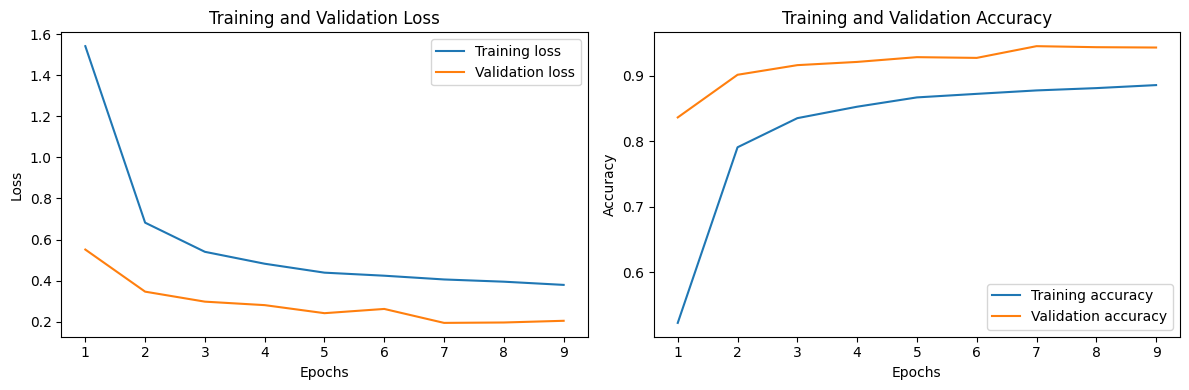

In [205]:
show_history(history)

### Tests

In [208]:
loss, accuracy = model.evaluate(add_cls_token(X_test, data_params['input_dim']), y_test_categorical)
print("Accuracy on test : ", accuracy)

362/362 [==============================] - 6s 15ms/step - loss: 0.2058 - accuracy: 0.9424
Accuracy on test :  0.9424124360084534


### Analysis of the model

#### Protein embeddings

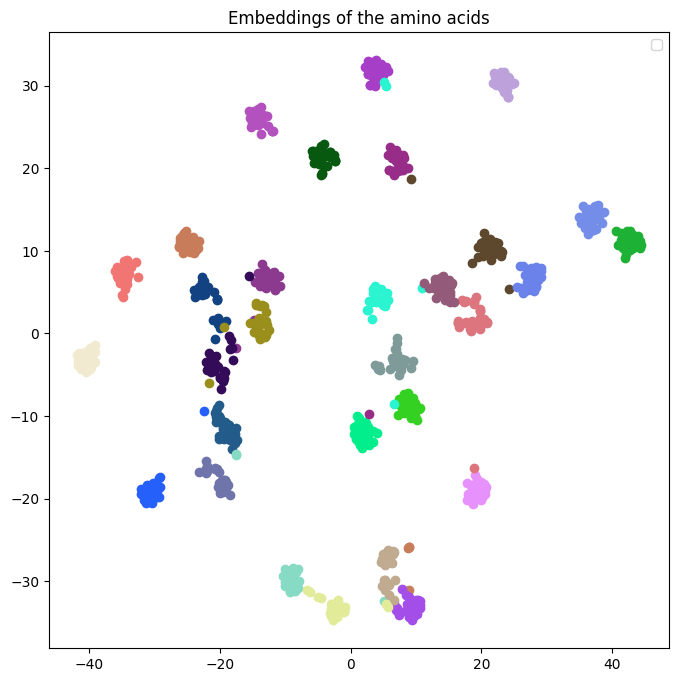

In [210]:
visualize_protein_embeddings(model, add_cls_token(X_train, data_params['input_dim']), y_train, nb_classes_to_analyze=30, nb_proteins_per_class=30)

# Ensemble method

## Model creation

In [223]:
class EnsembleClassifier:
    def __init__(self, base_model, num_models, *args, **kwargs):
        """
        Initialize an ensemble of classification models.

        Args:
            base_model (class): The base model class to use for creating each model in the ensemble.
            num_models (int): The number of models in the ensemble.
            *args: Positional arguments to be passed when creating the models.
            **kwargs: Keyword arguments to be passed when creating the models.

        """
        self.models = []
        self.base_model = base_model
        self.num_models = num_models
        self.args = args
        self.kwargs = kwargs

        for _ in range(num_models):
            model = self.base_model(*self.args, **self.kwargs)
            self.models.append(model)

    def compile(self, optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']):
        for model in self.models:
            model.compile(optimizer=optimizer,
                          loss=loss,
                          metrics=metrics)

    def fit(self, X, y_categorical, epochs, batch_size, early_stopping_patience, validation_data=None, class_weight=None, **kwargs):
        early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                       min_delta=0,
                                                       patience=early_stopping_patience,
                                                       verbose=0,
                                                       mode='auto')

        for i, model in enumerate(self.models):
            print(f"Training model {i+1}/{len(self.models)}...")
            indices = np.random.choice(len(X), size=len(X))
            X_bootstrap = X[indices]
            y_categorical_bootstrap = y_categorical[indices]
            model.fit(X_bootstrap,
                      y_categorical_bootstrap,
                      epochs=epochs,
                      batch_size=batch_size,
                      validation_data=validation_data,
                      class_weight=class_weight,
                      callbacks=[early_stopping])

    def compute_accuracy(self, X, y, num_classes):
        predictions = [model.predict(X) for model in self.models]
        all_predictions = np.array(predictions)
        result = np.zeros((self.num_models, X.shape[0], num_classes))

        for i in range(self.num_models):
            predictions_for_i_models = all_predictions[:i+1]
            mean_predictions = np.mean(predictions_for_i_models, axis=0)
            result[i] = mean_predictions

        preds_by_group_of_models = np.argmax(result, axis=2)
        list_accuracy = []

        for y_preds in preds_by_group_of_models:
            list_accuracy.append(sklearn.metrics.accuracy_score(y_preds, y_test))

        return list_accuracy

### Hyperparameters

For the hyperparameters, I simply used the better hyperparameters I found for the CNN.

In [225]:
base_model = CNN
num_models = 15

embedding_params = {
    'embedding_output_dim': 20,
    'embedding_by_position': False
}
model_params = {
    'nb_filters_per_kernel_size': 32,
    'kernel_sizes': [7, 11, 15, 17, 19, 21, 23, 25],
    'nb_dense_units': 256,
    'dropout_rate': 0.3
}
training_params = {
    'learning_rate': 1e-3,
    'batch_size': 64,
    'epochs': 30,
    'early_stopping_patience': 2,
    'validation_data': (X_dev, y_dev_categorical),
    'class_weight': class_weight_dict
}

### Train

In [226]:
ensemble_model = EnsembleClassifier(base_model, num_models=num_models, **data_params, **embedding_params, **model_params)

ensemble_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(training_params['learning_rate']),
                       loss='categorical_crossentropy',
                       metrics=['accuracy']) # sparse_categorical_crossentropy

ensemble_model.fit(X_train,
                   y_train_categorical,
                   **training_params)

Training model 1/15...
Epoch 1/30
1453/1453 [==============================] - 25s 16ms/step - loss: 0.2279 - accuracy: 0.9451 - val_loss: 0.0188 - val_accuracy: 0.9952
Epoch 2/30
1453/1453 [==============================] - 22s 15ms/step - loss: 0.0117 - accuracy: 0.9968 - val_loss: 0.0158 - val_accuracy: 0.9956
Epoch 3/30
1453/1453 [==============================] - 22s 15ms/step - loss: 0.0070 - accuracy: 0.9978 - val_loss: 0.0159 - val_accuracy: 0.9958
Epoch 4/30
1453/1453 [==============================] - 23s 16ms/step - loss: 0.0053 - accuracy: 0.9985 - val_loss: 0.0168 - val_accuracy: 0.9966
Training model 2/15...
Epoch 1/30
1453/1453 [==============================] - 23s 15ms/step - loss: 0.4585 - accuracy: 0.8845 - val_loss: 0.0377 - val_accuracy: 0.9913
Epoch 2/30
1453/1453 [==============================] - 21s 15ms/step - loss: 0.0300 - accuracy: 0.9915 - val_loss: 0.0250 - val_accuracy: 0.9943
Epoch 3/30
1453/1453 [==============================] - 22s 15ms/step - loss: 

### Tests

In [227]:
accuracy_list = ensemble_model.compute_accuracy(X_test, y_test, num_classes=data_params['num_classes'])

362/362 [==============================] - 1s 3ms/step


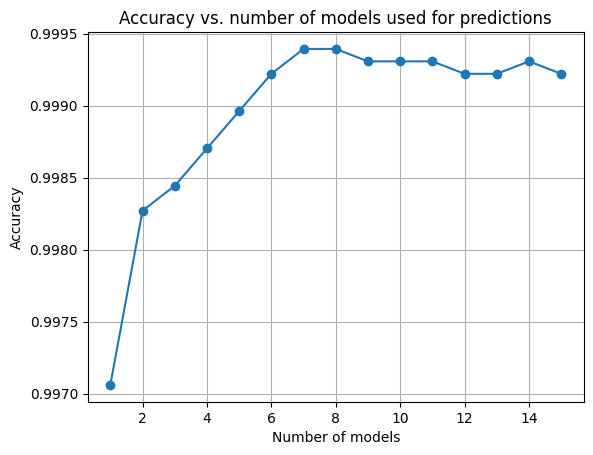

In [228]:
best_accuracy_index = np.argmax(accuracy_list)
best_accuracy = accuracy_list[best_accuracy_index]

plt.plot(range(1, len(accuracy_list) + 1), accuracy_list, marker='o', linestyle='-')
plt.xlabel('Number of models')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. number of models used for predictions')
plt.grid(True)

plt.show()

In [229]:
print(f"Best accuracy : {best_accuracy}\nObtained with {best_accuracy_index + 1} models\n")

Best accuracy : 0.9993947254647644
Obtained with 7 models

